In [1]:
#A code to analyze image cubes from the JWST nirspec ifu - examples here are done with CO
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d #UnivariateSpline
import os
import sys

from astropy.io import fits #, ascii
from astropy import units as u
import pandas as pd
from spectral_cube import SpectralCube

# Collect lab values
Like Einstein coefficients

In [2]:
#reading in from line list for CO
#done first so we can add it to our long table!
# columns = A, sec-1	E_u/k	g_u
table_path = '../Line list 2.1 for python.xlsx'
column_names = ['Wv, microns', 'A, sec-1', 'E_u/k', 'g_u']
co_lab_props = pd.read_excel(table_path, sheet_name='CO', usecols=column_names)

# Cross-correlation to see if absorption or emission (per line); radial velocity shift
First apply to B335

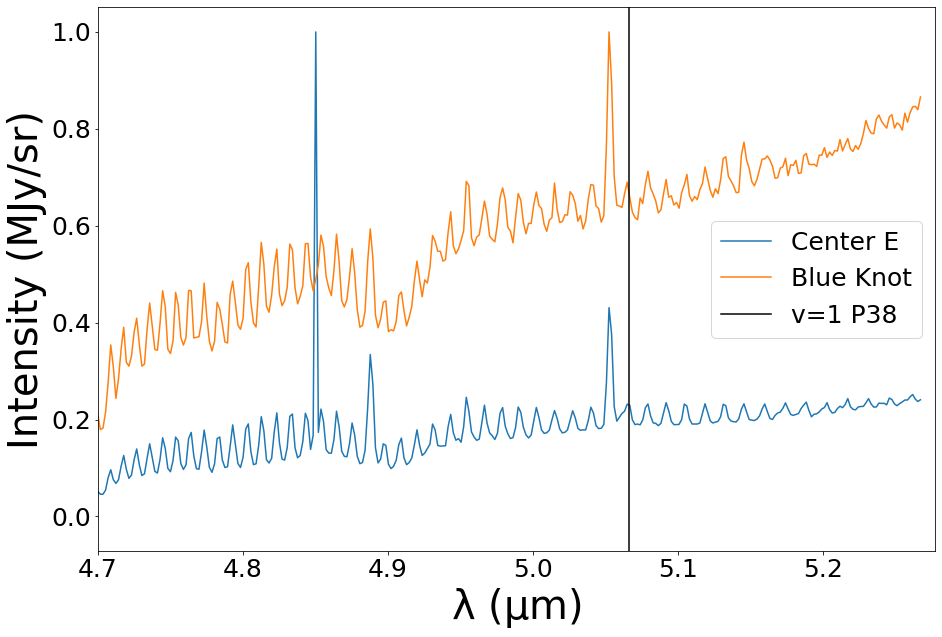

In [51]:
#packages for cross-correlating
from scipy import signal

#read in a list of spectral cubes to extract wcs headers...
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental, from cube fitting, needed to fix wavelengths we're using here
protostar_folders = ['../B335/']
cube_file_list = [glob(i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!
b335_locs = [(46,45), (28, 44)] # (56,41), (55, 46), 
loc_labels = ['Center E', 'Blue Knot'] #'Center NW', 'Center SW', 

#go through all files
for protostar_count, filepath in enumerate(cube_file_list):
    #open and read a data file
    hdul = fits.open(filepath)
    jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
    jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
    jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]

    #set up arrays to be read in...
    wave_offset_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
    absorp_emiss_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros

    #test spaxels
    fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes

    #loop through sources
    for source_ind in range(len(b335_locs)):
        i, j = b335_locs[source_ind] #locate spaxel of interest
        jwst_spaxel = np.sum(jwst_data[:,i-5:i+5,j-5:j+5], axis=(1,2)) #extract spectrum
        ax.plot(jwst_cube_wave, jwst_spaxel / np.max(jwst_spaxel), label=loc_labels[source_ind]) #plot original spectrum

        #try out cross correlation to determine shifts and whether absorption or emission
        # signal.correlate(, wave_axis+offset)

    #plotting a couple bright lines for reference     # co_bright_wave_list = [5.066134734]
    ax.axvline(5.06613, 0, 1, color='black', label='v=1 P38')

    ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
    ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40) #need to set the xlabel here first
    ax.legend(loc='best', fontsize=25)
    ax.set_xlim(4.7, np.max(jwst_cube_wave) + 0.01)
    # ax.set_ylim(np.min(avg_orig_slab[1200:])/1.05, np.max(avg_orig_slab[1200:])/1.01)
    # ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=25)

-230
288


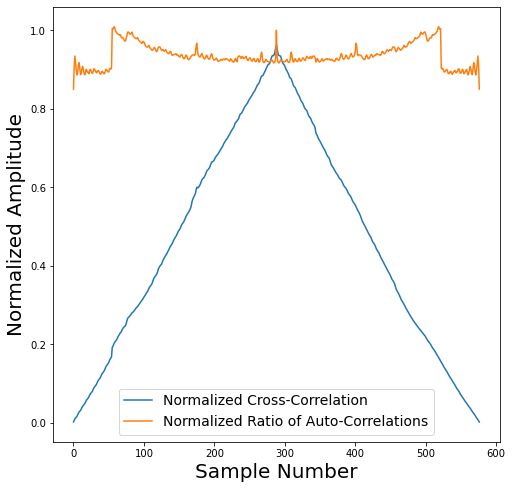

In [74]:
#loop through sources
jwst_source_spectra = []
for source_ind in range(len(b335_locs)):
    wave_mask = jwst_cube_wave > 4.75 #>4.4 microns
    i, j = b335_locs[source_ind] #locate spaxel of interest
    jwst_spaxel = np.sum(jwst_data[:,i-5:i+5,j-5:j+5], axis=(1,2)) #extract spectrum
    jwst_source_spectra.append(jwst_spaxel[wave_mask])
    # ax.plot(jwst_cube_wave, jwst_spaxel / np.max(jwst_spaxel), label=loc_labels[source_ind]) #plot original spectrum

#try out cross correlation to determine shifts and whether absorption or emission
auto_corr_center = signal.correlate(jwst_source_spectra[0], jwst_source_spectra[0])
auto_corr_blueblob = signal.correlate(jwst_source_spectra[1], jwst_source_spectra[1])
cross_corr = signal.correlate(jwst_source_spectra[0], jwst_source_spectra[1])

auto_ratio_norm = auto_corr_center / (np.linalg.norm(jwst_source_spectra[0]) * np.linalg.norm(jwst_source_spectra[0])) \
         / (auto_corr_blueblob / (np.linalg.norm(jwst_source_spectra[1]) * np.linalg.norm(jwst_source_spectra[1])))

cross_corr_norm = cross_corr / (np.linalg.norm(jwst_source_spectra[1]) * np.linalg.norm(jwst_source_spectra[0]))

corr_norm_diff = auto_corr_center / (np.linalg.norm(jwst_source_spectra[0]) * np.linalg.norm(jwst_source_spectra[0])) - auto_corr_blueblob - cross_corr_norm

#plot attempts mostly showing same thing (triangles)
plt.figure(figsize=(8,8))
# plt.plot(auto_corr_center)
# plt.plot(cross_corr)
# plt.plot(auto_corr_center / (np.linalg.norm(jwst_source_spectra[0]) * np.linalg.norm(jwst_source_spectra[0])) - auto_corr_blueblob - \
#             cross_corr_norm )
# plt.xlim(200, 350)
# plt.yscale('log')
# plt.ylim(2e6, 1.5e7)
# plt.axvline(260)

#gets a normalized triangular shape, see https://stackoverflow.com/questions/66282740/cross-correlate-misunderstanding-why-does-it-look-like-a-triangle-why-wont-it#:~:text=As%20for%20why%20it%20looks,one%20signal%20over%20the%20other.
#but that is because of averaging both negative and positive lags...
plt.plot(cross_corr_norm, label='Normalized Cross-Correlation')
plt.plot(auto_ratio_norm, label='Normalized Ratio of Auto-Correlations' )
plt.legend(fontsize=14)
# plt.xlim(200, 350)
# plt.yscale('log')
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Normalized Amplitude', fontsize=20)

#for more see https://stackoverflow.com/questions/13439718/how-to-interpret-the-values-returned-by-numpy-correlate-and-numpy-corrcoef
#or wikipedia page for the correlogram!

#another attempt to actually quantify the delay...
# max_ind_crosscorr = np.argmin(np.abs(np.max(cross_corr) - cross_corr))
# max_ind_autocorr = np.argmin(np.abs(np.max(auto_corr_center) - auto_corr_center))
# print(jwst_cube_wave[wave_mask][max_ind_crosscorr] - jwst_cube_wave[wave_mask][max_ind_autocorr])

lags = signal.correlation_lags(jwst_source_spectra[0].size, jwst_source_spectra[1].size, mode="full")
print(lags[np.argmax(auto_ratio_norm)])
print(lags[np.argmax(corr_norm_diff)])




Then apply to entire cubes

In [4]:
#read in a list of spectral cubes to extract wcs headers...
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental, from cube fitting, needed to fix wavelengths we're using here
protostar_folders = ['IRAS16253/', 'B335/', 'HOPS153/', 'HOPS370/', 'IRAS20126/']
cube_file_list = [glob(i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!

#go through all files
for protostar_count, filepath in enumerate(cube_file_list):
    #open and read a data file
    hdul = fits.open(filepath)
    jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
    jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
    jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]

    #set up arrays to be read in...
    wave_offset_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
    absorp_emiss_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros

    #by explicit loops
    for i in range(jwst_data.shape[1]):
        for j in range(jwst_data.shape[2]):
            crosscorr(jwst_data[:,i,j], wave_axis+offset)

IndexError: list index out of range